In [ ]:
!pip install -U transformers datasets accelerate sacrebleu

Supervised Fine-Tuning (SFT)

In [ ]:
from datasets import load_dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSeq2SeqLM,
    Seq2SeqTrainer,
    Seq2SeqTrainingArguments
)
import torch

# ============================================================
# LOAD DỮ LIỆU SONG NGỮ
# ============================================================
dataset = load_dataset(
    "harouzie/vi_en-translation",
    split="train",
    token=""
).shuffle(seed=42).select(range(5000))

# ============================================================
# CHIA TẬP TRAIN / TEST
# ============================================================
split_ds = dataset.train_test_split(test_size=0.1, seed=42)
train_ds, eval_ds = split_ds["train"], split_ds["test"]


In [ ]:
print(train_ds)
print(eval_ds)
# ============================================================
print("\nDữ liệu trong tập train:")
for i in range(3):
    print(f"\nEnglish: {train_ds[i]['English']}")
    print(f"Vietnamese: {train_ds[i]['Vietnamese']}")

Dataset({
    features: ['English', 'Vietnamese'],
    num_rows: 4500
})
Dataset({
    features: ['English', 'Vietnamese'],
    num_rows: 500
})

Dữ liệu trong tập train:

English: Is there a tennis court around here?
Vietnamese: Có một sân tennis quanh đây không?

English: I want you to promise me something.
Vietnamese: tôi muốn bạn hứa với tôi một cái gì đó

English: Thank you for your kind assistance.
Vietnamese: cảm ơn sự giúp đỡ của bạn


In [ ]:
# ============================================================
# LOAD TOKENIZER & MODEL (base)
# ============================================================
model_id = "google/mt5-base"
tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForSeq2SeqLM.from_pretrained(model_id)

In [ ]:
# ============================================================
# HÀM TIỀN XỬ LÝ
# ============================================================
max_length = 128
prefix = "translate English to Vietnamese: "

def preprocess_function(examples):
    inputs = [prefix + ex for ex in examples["English"]]
    targets = [ex for ex in examples["Vietnamese"]]

    # Tokenize input
    model_inputs = tokenizer(
        inputs,
        max_length=max_length,
        padding="max_length",
        truncation=True
    )

    # Tokenize labels
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(
            targets,
            max_length=max_length,
            padding="max_length",
            truncation=True
        )

    # Đổi mọi pad_token_id (0) thành -100
    labels["input_ids"] = [
        [(l if l != tokenizer.pad_token_id else -100) for l in label]
        for label in labels["input_ids"]
    ]

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

# Áp dụng tiền xử lý
tokenized_train = train_ds.map(preprocess_function, batched=True, remove_columns=train_ds.column_names)
tokenized_eval  = eval_ds.map(preprocess_function, batched=True, remove_columns=eval_ds.column_names)


In [ ]:
print(tokenized_train[0]["labels"][:20])

[13426, 326, 1266, 259, 27678, 51873, 3084, 334, 6847, 276, 1284, 291, 1, -100, -100, -100, -100, -100, -100, -100]


In [ ]:
from transformers import Seq2SeqTrainingArguments

training_args = Seq2SeqTrainingArguments(
    output_dir="./mt5_envit5_style/",     # Thư mục lưu model
    num_train_epochs=3,                   # Số epoch (1 để test, 3 để fine-tune thật)
    learning_rate=2e-4,                   # Tốc độ học
    per_device_train_batch_size=1,        # Batch size train
    per_device_eval_batch_size=1,         # Batch size eval
    gradient_accumulation_steps=4,        # Tăng batch ảo (4 bước mới update 1 lần)
    warmup_ratio=0.03,                    # Warmup 3% bước đầu
    logging_dir="./logs",                 # Nơi lưu log TensorBoard
    logging_strategy="steps",             # Log mỗi vài step
    logging_steps=10,                     # Mỗi 10 bước in loss ra
    save_total_limit=2,                   # Giữ tối đa 2 checkpoint
    report_to="none",                     # Không dùng WandB
    fp16=False,                           # Tắt FP16 để tránh loss=0 trên T4/3050
    bf16=False,                           # Không dùng BF16 (chỉ A100 mới hỗ trợ tốt)
    predict_with_generate=True,           # Cho phép generate khi eval
)


In [ ]:
# ============================================================
# HUẤN LUYỆN MÔ HÌNH (TRAINING)
# ============================================================
from transformers import Seq2SeqTrainer

trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_eval,
    tokenizer=tokenizer,
)

/tmp/ipython-input-3571522057.py:6: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


In [ ]:
print("Sample input_ids:", tokenized_train[0]["input_ids"][:20])
print("Sample labels:", tokenized_train[0]["labels"][:20])

Sample input_ids: [37194, 5413, 288, 259, 134126, 267, 2485, 2108, 259, 262, 51873, 15557, 5945, 2847, 291, 1, 0, 0, 0, 0]
Sample labels: [13426, 326, 1266, 259, 27678, 51873, 3084, 334, 6847, 276, 1284, 291, 1, -100, -100, -100, -100, -100, -100, -100]


In [ ]:
trainer.train()

In [ ]:
save_dir = "./mt5_envit5_style/"
print(f"Lưu mô hình vào: {save_dir}")
trainer.save_model(save_dir)
tokenizer.save_pretrained(save_dir)

Lưu mô hình vào: ./mt5_envit5_style/


('./mt5_envit5_style/tokenizer_config.json',
 './mt5_envit5_style/special_tokens_map.json',
 './mt5_envit5_style/spiece.model',
 './mt5_envit5_style/added_tokens.json',
 './mt5_envit5_style/tokenizer.json')

In [ ]:
# ============================================================
# KIỂM TRA DỊCH
# ============================================================
model = AutoModelForSeq2SeqLM.from_pretrained(
    "./mt5_envit5_style/",
    device_map="auto",
    dtype=torch.bfloat16
)
tokenizer = AutoTokenizer.from_pretrained("./mt5_envit5_style/")

def translate_en_to_vi(text):
    input_text = "translate English to Vietnamese: " + text
    inputs = tokenizer(input_text, return_tensors="pt", truncation=True).to(model.device)
    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=128,
            num_beams=4,
            temperature=0.7,
            top_p=0.9
        )
    return tokenizer.decode(outputs[0], skip_special_tokens=True)

In [ ]:
# Test
test_sentences = [
    "He is a good teacher.",
    "She doesn’t like coffee.",
    "The meeting was postponed due to heavy rain.",
    "This book contains many useful lessons about life.",
    "I haven’t finished my homework yet.",
    "He didn’t understand what I said.",
    "The concert will start at 8 p.m.",
    "We met each other five years ago.",
    "How are you today?",
    "Can you help me with this problem?",
    "Machine learning models require large amounts of data to perform well.",
    "Natural language processing enables computers to understand human language.",
    "Climate change is one of the biggest challenges of our time.",
    "More people are working remotely than ever before.",
]

for s in test_sentences:
    print(f"\nEnglish: {s}")
    print(f"Vietnamese: {translate_en_to_vi(s)}")


English: He is a good teacher.
Vietnamese: anh ấy là một giáo viên giỏi.

English: She doesn’t like coffee.
Vietnamese: cô ấy không thích cà phê.

English: The meeting was postponed due to heavy rain.
Vietnamese: một cuộc họp đã bị nghỉ nghỉ vì mưa lạnh.

English: This book contains many useful lessons about life.
Vietnamese: của cuốn sách này có nhiều bài học hữu ích về cuộc sống.

English: I haven’t finished my homework yet.
Vietnamese: tôi chưa hoàn thành bài tập của tôi chưa.

English: He didn’t understand what I said.
Vietnamese: anh ấy không hiểu những gì tôi nói.

English: The concert will start at 8 p.m.
Vietnamese: bữa tiệc sẽ bắt đầu lúc 8 giờ

English: We met each other five years ago.
Vietnamese: chúng tôi đã gặp nhau ba năm trước.

English: How are you today?
Vietnamese: bây giờ bạn thế nào?

English: Can you help me with this problem?
Vietnamese: bạn có thể giúp tôi với vấn đề này không?

English: Machine learning models require large amounts of data to perform well.
Vie

Reinforcement Learning (RL)

In [ ]:
from datasets import load_dataset
import json

# ============================================================
# Load & shuffle dataset giống hệt SFT (seed=42)
# ============================================================
print("Đang tải dữ liệu gốc...")
full_ds = load_dataset(
    "harouzie/vi_en-translation",
    split="train",
    token=""
).shuffle(seed=42)
print("Tổng số mẫu:", len(full_ds))

# ============================================================
# Chọn 2k câu cho RL (PPO) và 1k câu cho test
# ============================================================
ppo_ds = full_ds.select(range(5000, 7000))   # 2000 mẫu RL
test_ds = full_ds.select(range(7000, 8000))  # 1000 mẫu Test

# ============================================================
# Lưu ra file JSONL
# ============================================================
def save_jsonl(dataset, path):
    with open(path, "w", encoding="utf-8") as f:
        for ex in dataset:
            f.write(json.dumps({
                "English": ex["English"],
                "Vietnamese": ex["Vietnamese"]
            }, ensure_ascii=False) + "\n")
    print(f"Đã lưu {path} ({len(dataset)} mẫu)")
save_jsonl(ppo_ds, "ppo_dataset.jsonl")
save_jsonl(test_ds, "test_dataset.jsonl")
print("\nHoàn tất tách dữ liệu")

Đang tải dữ liệu gốc...
Tổng số mẫu: 203272
Đã lưu ppo_dataset.jsonl (2000 mẫu)
Đã lưu test_dataset.jsonl (1000 mẫu)

Hoàn tất tách dữ liệu


In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
from datasets import load_dataset
import sacrebleu
from torch.optim import AdamW
from statistics import mean
import time
# ============================================================
# LOAD CHECKPOINT SFT & TOKENIZER
# ============================================================
model_name = "/content/drive/MyDrive/Colab Notebooks/Học sâu/mt5_envit5_style"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSeq2SeqLM.from_pretrained(model_name).to("cuda")
# Optimizer cho RL phase
optimizer = AdamW(model.parameters(), lr=1e-5)

In [ ]:
# ============================================================
# LOAD PPO DATASET
# ============================================================
ppo_ds = load_dataset("json", data_files="ppo_dataset.jsonl")["train"]
print("PPO dataset size:", len(ppo_ds))

In [ ]:
# ============================================================
# HIỂN THỊ MỘT SỐ MẪU DỮ LIỆU PPO
# ============================================================
print("\n===== SAMPLE PPO DATA =====")
for i in range(5):
    print(f"\n{i+1}. English: {ppo_ds[i]['English']}")
    print(f"   Vietnamese: {ppo_ds[i]['Vietnamese']}")


===== SAMPLE PPO DATA =====

1. English: We are anxious about her health.
   Vietnamese: chúng tôi lo lắng về sức khỏe của cô ấy

2. English: Once you get to know her, she is very friendly
   Vietnamese: Một khi bạn quen cô ấy, cô ấy rất thân thiện.

3. English: I'll see you in a little while
   Vietnamese: tôi sẽ gặp bạn sau

4. English: I will leave it to your judgement
   Vietnamese: tôi sẽ để nó ra phán xét của bạn

5. English: Get out of my kitchen.
   Vietnamese: ra khỏi bếp của tôi


In [ ]:
# ============================================================
# HÀM TÍNH REWARD (BLEU)
# ============================================================
def compute_reward(pred, ref):
    bleu = sacrebleu.sentence_bleu(pred, [ref], smooth_method="exp")
    return bleu.score / 100.0  # Chuẩn hóa về 0–1

Dùng phương pháp PPO

In [ ]:
# ============================================================
# TRAIN LOOP
# ============================================================
max_samples = len(ppo_ds)
reward_history = []

EPOCHS = 1
for epoch in range(1, EPOCHS + 1):
    print(f"\n===== EPOCH {epoch}/{EPOCHS} =====")
    t0 = time.time()
    reward_epoch = []

    for i, ex in enumerate(ppo_ds):
        src = "translate English to Vietnamese: " + ex["English"]
        tgt = ex["Vietnamese"]

        # Encode input + label
        inputs = tokenizer(src, return_tensors="pt", truncation=True, max_length=128, padding=True).to("cuda")
        labels = tokenizer(tgt, return_tensors="pt", truncation=True, max_length=128).input_ids.to("cuda")

        # --- Generate translation ---
        with torch.no_grad():
            gen = model.generate(**inputs, max_new_tokens=64)
        pred = tokenizer.decode(gen[0], skip_special_tokens=True)

        # --- Reward BLEU ---
        reward = compute_reward(pred, tgt)
        reward = max(0.0, min(reward, 1.0))
        reward_history.append(reward)
        reward_epoch.append(reward)

        # --- Forward để lấy log-prob ---
        out = model(**inputs, labels=labels)
        log_probs = out.logits.log_softmax(-1)
        token_logp = torch.gather(log_probs, -1, labels.unsqueeze(-1)).mean()

        # --- REINFORCE LOSS (không baseline) ---
        loss = -reward * token_logp

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        if (i + 1) % 100 == 0:
            avg_r = mean(reward_epoch[-100:])
            print(f"Step {i+1}/{max_samples} | Avg Reward: {avg_r*100:.2f}")


===== EPOCH 1/1 =====
Step 100/2000 | Avg Reward: 35.17
Step 200/2000 | Avg Reward: 38.40
Step 300/2000 | Avg Reward: 34.21
Step 400/2000 | Avg Reward: 37.92
Step 500/2000 | Avg Reward: 35.75
Step 600/2000 | Avg Reward: 37.74
Step 700/2000 | Avg Reward: 41.77
Step 800/2000 | Avg Reward: 34.47
Step 900/2000 | Avg Reward: 34.83
Step 1000/2000 | Avg Reward: 37.49
Step 1100/2000 | Avg Reward: 34.89
Step 1200/2000 | Avg Reward: 38.38
Step 1300/2000 | Avg Reward: 40.63
Step 1400/2000 | Avg Reward: 35.59
Step 1500/2000 | Avg Reward: 39.19
Step 1600/2000 | Avg Reward: 37.36
Step 1700/2000 | Avg Reward: 42.10
Step 1800/2000 | Avg Reward: 37.94
Step 1900/2000 | Avg Reward: 37.05
Step 2000/2000 | Avg Reward: 37.13


In [ ]:
# ============================================================
# LƯU MODEL SAU KHI RL
# ============================================================
save_dir = "./mt5_envit5_rl"
model.save_pretrained(save_dir)
tokenizer.save_pretrained(save_dir)
print(f"\nĐã lưu model RL vào: {save_dir}")


Đã lưu model RL vào: ./mt5_envit5_rl


In [ ]:
model_path = "./mt5_envit5_rl"
model = AutoModelForSeq2SeqLM.from_pretrained(model_path).to("cuda")
tokenizer = AutoTokenizer.from_pretrained(model_path)
print("Đã load model RL thành công!")

Đã load model RL thành công!


In [ ]:
def translate_en_to_vi(text):
    input_text = "translate English to Vietnamese: " + text
    inputs = tokenizer(input_text, return_tensors="pt", truncation=True).to(model.device)
    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=128,
            num_beams=4,
            temperature=0.7,
            top_p=0.9
        )
    return tokenizer.decode(outputs[0], skip_special_tokens=True)

In [ ]:
# Test
test_sentences = [
    "He is a good teacher.",
    "She doesn’t like coffee.",
    "We met each other five years ago.",
    "The concert will start at 8 p.m.",
    "Can you help me with this problem?",
    "How are you today?",
    "I haven’t finished my homework yet.",
    "He didn’t understand what I said.",
    "I love watching the sunset at the beach.",
    "They moved to a new apartment last month.",
    "The meeting was postponed due to heavy rain.",
    "It’s going to be very cold tomorrow morning.",
    "The air in big cities is becoming more polluted.",
    "Our teacher gave us a difficult assignment yesterday.",
    "Doctors recommend drinking enough water every day.",
    "More people are working remotely than ever before.",
    "The internet has changed the way we communicate.",
    "She was surprised to see him at the party.",
    "I miss my family when I travel abroad.",
    "They have been best friends since childhood.",
]

for s in test_sentences:
    print(f"\nEnglish: {s}")
    print(f"Vietnamese: {translate_en_to_vi(s)}")


English: He is a good teacher.
Vietnamese: anh ấy là một giáo viên giỏi.

English: She doesn’t like coffee.
Vietnamese: cô ấy không thích cà phê.

English: We met each other five years ago.
Vietnamese: chúng tôi đã gặp nhau năm trước.

English: The concert will start at 8 p.m.
Vietnamese: bữa tiệc sẽ bắt đầu lúc 8 giờ

English: Can you help me with this problem?
Vietnamese: bạn có thể giúp tôi với vấn đề này không?

English: How are you today?
Vietnamese: hôm nay bạn thế nào

English: I haven’t finished my homework yet.
Vietnamese: tôi chưa hoàn thành bài tập của mình

English: He didn’t understand what I said.
Vietnamese: anh ấy không hiểu những gì tôi nói.

English: I love watching the sunset at the beach.
Vietnamese: tôi thích xem trời sáng tại bãi biển.

English: They moved to a new apartment last month.
Vietnamese: họ đã chuyển đến một ngôi nhà mới tháng trước.

English: The meeting was postponed due to heavy rain.
Vietnamese: một cuộc họp được từ chối vì mưa lạnh.

English: It’s

So sánh

Load lại mt5-base để đánh giá

In [ ]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
import torch

# Load mT5-base gốc (chưa fine-tune)
base_model_id = "google/mt5-base"
model = AutoModelForSeq2SeqLM.from_pretrained(
    base_model_id,
    device_map="auto",
    torch_dtype=torch.float32
).to("cuda" if torch.cuda.is_available() else "cpu")
tokenizer = AutoTokenizer.from_pretrained(base_model_id)


Do mt5-base chưa dịch được nên không so sánh

In [ ]:
# Test
test_sentences = [
    "He is a good teacher.",
    "She doesn’t like coffee.",
    "We met each other five years ago.",
    "The concert will start at 8 p.m.",
]

for s in test_sentences:
    print(f"\nEnglish: {s}")
    print(f"Vietnamese: {translate_en_to_vi(s)}")

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



English: He is a good teacher.
Vietnamese: <extra_id_0> Vietnamese

English: She doesn’t like coffee.
Vietnamese: <extra_id_0> English to Vietnamese

English: We met each other five years ago.
Vietnamese: <extra_id_0> Vietnamese

English: The concert will start at 8 p.m.
Vietnamese: <extra_id_0>.com.


So sánh 2 thuật toán SFT và RL

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
import sacrebleu
import json

# ============================================================
# HÀM DỊCH & ĐÁNH GIÁ BLEU
# ============================================================
def translate_batch(model, tokenizer, texts, max_samples=500):
    translations = []
    total = min(max_samples, len(texts))
    for i, text in enumerate(texts[:total], start=1):
        input_text = "translate English to Vietnamese: " + text
        inputs = tokenizer(input_text, return_tensors="pt", truncation=True, max_length=128).to(model.device)
        with torch.no_grad():
            outputs = model.generate(
                **inputs,
                max_new_tokens=128,
                num_beams=4,
                do_sample=False
            )
        trans = tokenizer.decode(outputs[0], skip_special_tokens=True)
        translations.append(trans)
    return translations

def evaluate_bleu(model_path, test_data, label):
    print(f"\n===== Evaluating {label} =====")
    model = AutoModelForSeq2SeqLM.from_pretrained(model_path).to("cuda")
    tokenizer = AutoTokenizer.from_pretrained(model_path)

    sources = [ex["English"] for ex in test_data]
    references = [[ex["Vietnamese"] for ex in test_data]]
    translations = translate_batch(model, tokenizer, sources, max_samples=500)

    bleu = sacrebleu.corpus_bleu(translations, references)
    print(f"{label} BLEU: {bleu.score:.2f}")

    return bleu.score, translations


# ============================================================
# LOAD TẬP TEST
# ============================================================
test_file = "test_dataset.jsonl"
with open(test_file, "r", encoding="utf-8") as f:
    test_data = [json.loads(line) for line in f]

# ============================================================
# ĐÁNH GIÁ CẢ 2 MÔ HÌNH
# ============================================================
bleu_sft, trans_sft = evaluate_bleu("/content/drive/MyDrive/Colab Notebooks/Học sâu/mt5_envit5_style", test_data, "SFT Model")
bleu_rl, trans_rl = evaluate_bleu("./mt5_envit5_rl", test_data, "RL Model")

# ============================================================
# HIỂN THỊ KẾT QUẢ SO SÁNH
# ============================================================
print("\n===== BLEU COMPARISON =====")
print(f"SFT Model BLEU: {bleu_sft:.2f}")
print(f"RL Model  BLEU: {bleu_rl:.2f}")
# ============================================================
# HIỂN THỊ MỘT SỐ VÍ DỤ
# ============================================================
print("\n===== SAMPLE TRANSLATIONS =====")
for i in range(5):
    print(f"\nEN: {test_data[i]['English']}")
    print(f"SFT: {trans_sft[i]}")
    print(f"RL : {trans_rl[i]}")
    print(f"REF: {test_data[i]['Vietnamese']}")



===== Evaluating SFT Model =====
SFT Model BLEU: 40.85

===== Evaluating RL Model =====
RL Model BLEU: 42.61

===== BLEU COMPARISON =====
SFT Model BLEU: 40.85
RL Model  BLEU: 42.61

===== SAMPLE TRANSLATIONS =====

EN: We're competitors, not partners.
SFT: chúng tôi không phải là khách hàng, không phải bạn.
RL : chúng tôi không phải là đối tác, không phải là khách hàng.
REF: chúng tôi là đối thủ cạnh tranh, không phải đối tác.

EN: Nothing makes Tom happy
SFT: không có gì làm tom hạnh phúc
RL : không có gì làm tom hạnh phúc
REF: không có gì làm cho tom hạnh phúc

EN: Tom doesn't understand because he wasn't paying attention
SFT: Tom không hiểu vì anh ấy không quan tâm
RL : Tom không hiểu vì anh ấy không quan tâm
REF: tom không hiểu vì anh không chú ý

EN: She is in the wrong
SFT: cô ấy đang sai
RL : cô ấy đã sai
REF: Cô là sai

EN: Why did you want us to come here?
SFT: Tại sao bạn muốn chúng tôi đến đây?
RL : Tại sao bạn muốn chúng tôi đến đây?
REF: tại sao bạn muốn chúng tôi đến đâ

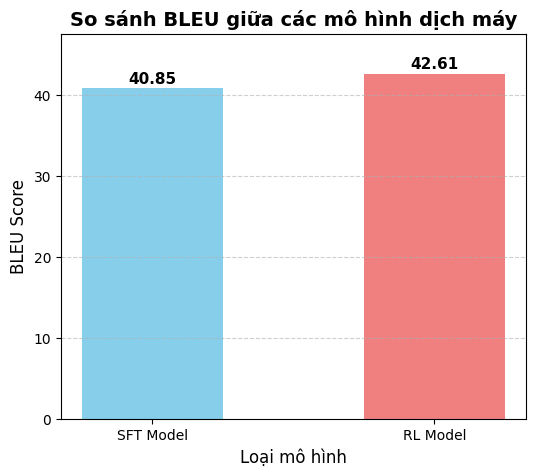

In [ ]:
import matplotlib.pyplot as plt
bleu_sft = bleu_sft     # BLEU model SFT
bleu_rl = bleu_rl       # BLEU model RL

# Danh sách mô hình và BLEU tương ứng
models = ['SFT Model', 'RL Model']
bleu_scores = [bleu_sft, bleu_rl]

# ============================================================
# VẼ BIỂU ĐỒ CỘT
# ============================================================
plt.figure(figsize=(6, 5))
bars = plt.bar(models, bleu_scores, color=['skyblue', 'lightcoral'], width=0.5)

# Ghi giá trị BLEU lên đầu mỗi cột
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.3, f"{yval:.2f}", ha='center', va='bottom', fontsize=11, fontweight='bold')

# Thêm tiêu đề và trục
plt.title("So sánh BLEU giữa các mô hình dịch máy", fontsize=14, fontweight='bold')
plt.ylabel("BLEU Score", fontsize=12)
plt.xlabel("Loại mô hình", fontsize=12)
plt.ylim(0, max(bleu_scores) + 5)

# Hiển thị
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()
